In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from time import time
import tflearn, psutil, gc
from datetime import datetime
%matplotlib inline

In [2]:
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.normalization import local_response_normalization
from tflearn.layers.estimator import regression

In [5]:
from rlx.utils import humanbytes
print "free mem", humanbytes(psutil.virtual_memory().free)

free mem 1.20 GB


# We will be creating the same CNN  for classify MNIST as in previous notes

## load the data

In [4]:
from tensorflow.examples.tutorials.mnist.input_data import read_data_sets
mnist = read_data_sets("/tmp/MNIST_data/", one_hot=True, reshape=False, validation_size=0)
print "free mem", humanbytes(psutil.virtual_memory().free)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting /tmp/MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting /tmp/MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/MNIST_data/t10k-labels-idx1-ubyte.gz
free mem 1.20 GB


In [6]:
print mnist.train.images.shape
print mnist.test.images.shape

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [7]:
# number of images used for training and test
n=10000

idxs = np.random.permutation(range(len(mnist.train.images)))[:n]
train_imgs = mnist.train.images[idxs]
train_ohlabs = mnist.train.labels[idxs]
train_labels = np.r_[[np.argwhere(i)[0][0] for i in train_ohlabs]]

In [8]:
vn = n if n<mnist.test.images.shape[0] else mnist.test.images.shape[0]

idxs = np.random.permutation(range(len(mnist.test.images)))[:n]
test_imgs = mnist.test.images[idxs]
test_ohlabs = mnist.test.labels[idxs]
test_labels = np.r_[[np.argwhere(i)[0][0] for i in test_ohlabs]]

In [9]:
print train_imgs.shape, test_imgs.shape
print "free mem", humanbytes(psutil.virtual_memory().free)

(10000, 28, 28, 1) (10000, 28, 28, 1)
free mem 1.16 GB


In [10]:
del(mnist)
gc.collect()
print "free mem", humanbytes(psutil.virtual_memory().free)

free mem 1.36 GB


In [11]:
print pd.Series(train_labels).value_counts()
print pd.Series(test_labels).value_counts()

1    1141
6    1041
3    1037
7    1022
0    1006
2     992
9     988
4     965
8     942
5     866
dtype: int64
1    1135
2    1032
7    1028
3    1010
9    1009
4     982
0     980
8     974
6     958
5     892
dtype: int64


## use `tflearn` to create network

In [12]:
num_classes = 10

tf.reset_default_graph()

network1 = input_data(shape=[None, 28, 28, 1])
network2 = conv_2d(network1, 9, 5, strides=1, activation='relu', name="conv1", padding="SAME")
network3 = conv_2d(network2, 18, 4, strides=2, activation='relu', name="conv2", padding="SAME")
network4 = fully_connected(network3, 100, activation='relu', name='fc1')
network5 = fully_connected(network4, 10, activation='softmax', name='fc2')
network6 = regression(network5, optimizer="adam",  loss='categorical_crossentropy')

model   = tflearn.DNN(network6, tensorboard_verbose=0, tensorboard_dir="log")
print type(model), type(network6)

Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
<class 'tflearn.models.dnn.DNN'> <class 'tensorflow.python.framework.ops.Tensor'>


In [13]:
gc.collect()
print "free mem", humanbytes(psutil.virtual_memory().free)

free mem 1.34 GB


In [15]:
vars = {i.name:i for i in tflearn.variables.get_all_trainable_variable()}
vars

{u'conv1/W:0': <tf.Variable 'conv1/W:0' shape=(5, 5, 1, 9) dtype=float32_ref>,
 u'conv1/b:0': <tf.Variable 'conv1/b:0' shape=(9,) dtype=float32_ref>,
 u'conv2/W:0': <tf.Variable 'conv2/W:0' shape=(4, 4, 9, 18) dtype=float32_ref>,
 u'conv2/b:0': <tf.Variable 'conv2/b:0' shape=(18,) dtype=float32_ref>,
 u'fc1/W:0': <tf.Variable 'fc1/W:0' shape=(3528, 100) dtype=float32_ref>,
 u'fc1/b:0': <tf.Variable 'fc1/b:0' shape=(100,) dtype=float32_ref>,
 u'fc2/W:0': <tf.Variable 'fc2/W:0' shape=(100, 10) dtype=float32_ref>,
 u'fc2/b:0': <tf.Variable 'fc2/b:0' shape=(10,) dtype=float32_ref>}

## train and use `tensorboard` to see progress and results

In [16]:
model_name = "tflearn_cnn_mnist_" + datetime.now().strftime("%Y-%m-%d_%H:%M")
print "model name", model_name

model name tflearn_cnn_mnist_2018-01-13_14:43


In [17]:
# Training
model.fit(train_imgs, train_ohlabs, n_epoch=10,  validation_set=(test_imgs, test_ohlabs), shuffle=True,
          show_metric=True, batch_size=100, snapshot_step=1000, snapshot_epoch=False, run_id=model_name)

Training Step: 999  | total loss: 0.01801 | time: 11.260s
| Adam | epoch: 010 | loss: 0.01801 - acc: 0.9956 -- iter: 09900/10000
Training Step: 1000  | total loss: 0.01666 | time: 15.191s
| Adam | epoch: 010 | loss: 0.01666 - acc: 0.9960 | val_loss: 0.07130 - val_acc: 0.9802 -- iter: 10000/10000
--


In [18]:
model.save("models/"+model_name)

INFO:tensorflow:/home/user/share/Dropbox/teaching/machine-learning/2018.cnn/student/notes_git/models/tflearn_cnn_mnist_2018-01-13_14:43 is not in all_model_checkpoint_paths. Manually adding it.


In [19]:
preds = model.predict(test_imgs)
print preds.shape
preds = np.argmax(preds, axis=1)
print preds.shape
print np.mean(test_labels == preds)

(10000, 10)
(10000,)
0.9802


In [20]:
gc.collect()
print "free mem", humanbytes(psutil.virtual_memory().free)

free mem 1.47 GB


## observe how TF variables are available through `tflearn`

In [21]:
vars = {i.name:i for i in tflearn.variables.get_all_variables()}
vars

{u'Accuracy/Mean/moving_avg:0': <tf.Variable 'Accuracy/Mean/moving_avg:0' shape=() dtype=float32_ref>,
 u'Adam/beta1_power:0': <tf.Variable 'Adam/beta1_power:0' shape=() dtype=float32_ref>,
 u'Adam/beta2_power:0': <tf.Variable 'Adam/beta2_power:0' shape=() dtype=float32_ref>,
 u'Crossentropy/Mean/moving_avg:0': <tf.Variable 'Crossentropy/Mean/moving_avg:0' shape=() dtype=float32_ref>,
 u'Global_Step:0': <tf.Variable 'Global_Step:0' shape=() dtype=float32_ref>,
 u'Training_step:0': <tf.Variable 'Training_step:0' shape=() dtype=float32_ref>,
 u'conv1/W/Adam:0': <tf.Variable 'conv1/W/Adam:0' shape=(5, 5, 1, 9) dtype=float32_ref>,
 u'conv1/W/Adam_1:0': <tf.Variable 'conv1/W/Adam_1:0' shape=(5, 5, 1, 9) dtype=float32_ref>,
 u'conv1/W:0': <tf.Variable 'conv1/W:0' shape=(5, 5, 1, 9) dtype=float32_ref>,
 u'conv1/b/Adam:0': <tf.Variable 'conv1/b/Adam:0' shape=(9,) dtype=float32_ref>,
 u'conv1/b/Adam_1:0': <tf.Variable 'conv1/b/Adam_1:0' shape=(9,) dtype=float32_ref>,
 u'conv1/b:0': <tf.Variable

In [22]:
w1 = model.get_weights(vars["conv1/W:0"])
b1 = model.get_weights(vars["conv1/b:0"])
w2 = model.get_weights(vars["conv2/W:0"])
fc1 = model.get_weights(vars["fc1/W:0"])
fc2 = model.get_weights(vars["fc2/W:0"])

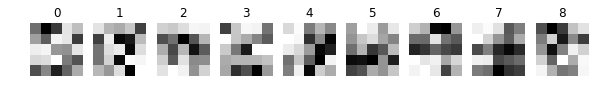

In [23]:
def display_imgs(w, figsize=(10,3)):
    plt.figure(figsize=figsize)
    for i in range(w.shape[-1]):
        plt.subplot(1,w.shape[-1],i+1)
        plt.imshow(w[:,:,i], cmap = plt.cm.Greys_r, interpolation="none")
        plt.axis("off")
        plt.title(i)
        
display_imgs(w1[:,:,0,:])

INFO:tensorflow:Restoring parameters from models/tflearn_cnn_mnist_2018-01-13_14:43


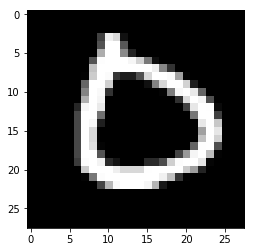

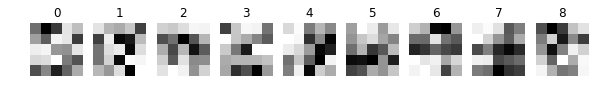

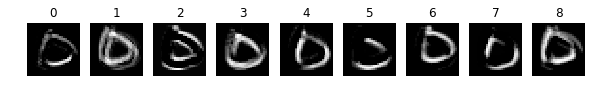

In [24]:
X = model.inputs[0]
i = np.random.randint(len(test_imgs))
with tf.Session() as sess:
    saver = tf.train.Saver()
    tflearn.config.init_training_mode()
    saver.restore(sess, "models/"+model_name)    
    activations_conv1, activations_fc1 = sess.run([network2, network4], feed_dict={X: test_imgs[i:i+1]})


plt.imshow(test_imgs[i][:,:,0], cmap=plt.cm.Greys_r)
display_imgs(w1[:,:,0,:])
display_imgs(activations_conv1[0,:,:,:])